# CS 109A/AC 209A/STAT 121A Data Science: Midterm 1
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split as sk_split


%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a Extension

## Asteroid

It is Oct 13, 2016. NASA's radars discovered a small, 3 meter, iron base meteorite that just entered the Earth's atmosphere.  A small meteorite will not create a wide-spread devastation but will still be dangerous for the citizens. Local authorities would like to know the location of the impact point so they that can warn residents and allocate resources based on the population affected.

The Governor has sought out the best data scientist in the state - you - to help save the day!

You are given two data sets:
1.  Radar position estimates (x, y, z - coordinates; z being the altitude) of the meteorite at various times are available here (https://cs109alabs.github.io/lab_files/). x, y, z coordinates are in kilometers and time is in seconds. 
2. Locations and other details of every dwelling in the town are provided here.  

I. Using methods you learned in class to estimate the expected point of impact along with the region with 90% certainty.  
II. Using the dwelling database, estimate the total number of people that will most likely be affected within this region.


----------

My initial models and plots related to creating models to solve the problem were all very consistent and reasonable, at least given the constraints of my approach. Then I tried to use them in conjunction with pop_data.csv and it was evident things had gone badly awry. I tried figuring out what was at fault (right now I'm suspecting the entirety of my approach) but certainly didn't have time to try something different. In the end I have some pretty plots and reasonable-looking numbers that I believe are rather useless. In the 'people affected' area I wind up using some dummy information, just so I can illustrate what my final calculations would have looked like.  

I began with the idea that two linear regression models could be created, one to estimate X-Coord from Z-Coord/Altitude values and another to do same for Y-Coord. All of the 130 data points would be used to create the models, and then '0' would be used as the single indepent variable value (Altitude) to predict X and Y coordinates. Which would wind up being the intercept of the two models.

In [2]:
# at the last moment, going to try to replace my read from manually munged index.csv with a scrape
# of the web page. Certainly, nothing could go wrong.

from bs4 import BeautifulSoup
import urllib

page = urllib.urlopen('https://cs109alabs.github.io/lab_files/')
soup = BeautifulSoup(page, 'lxml')
# print soup.prettify()[:1000]



In [3]:
table = soup.find('table')
headers = [header.text for header in table.find_all('th')]

rows = table.find_all('tr')
# print rows[0]

info = [headers]
for i, row in enumerate(rows):
    # get rid of the empty entry, prob from header row, this is quickest solution
    if i == 0:
        continue
    td = [float(td.text) for td in row.find_all('td')]
    info.append(td)

csv = pd.DataFrame(info[1:], columns=info[0])
csv = csv.rename(columns = {'Time': 'time', 'X-Coord': 'xc', 'Y-Coord': 'yc', 'Z-Coord': 'zc'})
csv.head()

,time,xc,yc,zc
0,0,48.829115,8.475321,17005.097685
1,10,69.150375,69.210754,16941.295532
2,20,177.877729,134.011776,16831.330330
3,30,199.734002,220.743524,16569.077982
4,40,278.017526,221.403121,16849.673012


In [4]:
# ok, 2 minutes before midterm submission, lets replace my .csv read with BeautifulSoup
# Fortes fortuna adjuvat

#data = pd.read_csv('index.csv')
# rename to something easier to refer to in code
#data = data.rename(columns = {'Time': 'time', 'X-Coord': 'xc', 'Y-Coord': 'yc', 'Z-Coord': 'zc'})
# data = data.sort('zc')
#data.head(10)

#try only with later data? data = data[50:]

In [5]:
# replace my initially read-from-csv-file with what I got from Soup
data = csv

In [6]:
print '''
xc and yc appear to be highly correlated, any reason to include one of those (in addition to xz/Atltitude)?

X-Coord / Y-Coord correlation matrix:'''
x_y_corr_matrix = np.corrcoef(data['xc'], data['yc'])
print x_y_corr_matrix
print '''
Doesn't look that way, they are indeed highly correlated. Not perfectly, will still need to create two models, 
but high enough that neither will be used as a predictor for the other.
'''


xc and yc appear to be highly correlated, any reason to include one of those (in addition to xz/Atltitude)?

X-Coord / Y-Coord correlation matrix:
[[ 1.         0.9997758]
 [ 0.9997758  1.       ]]

Doesn't look that way, they are indeed highly correlated. Not perfectly, will still need to create two models, 
but high enough that neither will be used as a predictor for the other.



plot Altitude vs. X-Coord and then vs. Y-Coord
observe that the two are very similar, and linear (with a slight curve)


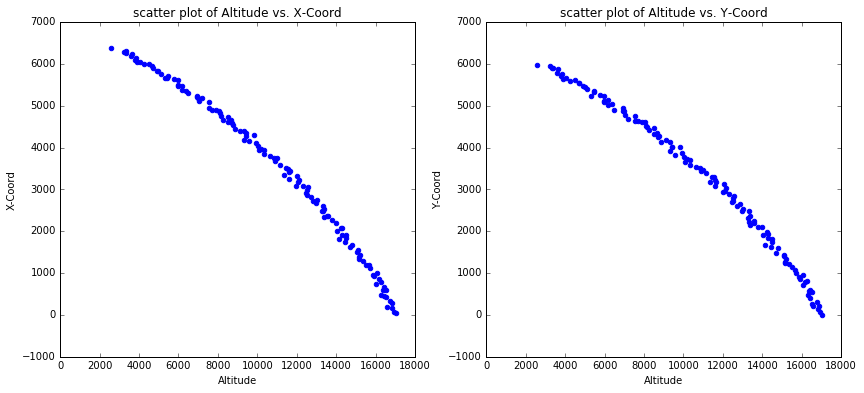

In [7]:
print 'plot Altitude vs. X-Coord and then vs. Y-Coord'
print 'observe that the two are very similar, and linear (with a slight curve)'
fig, ((axes_1, axes_2)) = plt.subplots(1, 2, figsize=(14, 6))

axes_1.scatter(data['zc'], 
            data['xc'], 
            color='blue')
axes_1.set_title('scatter plot of Altitude vs. X-Coord')
axes_1.set_xlabel('Altitude')
axes_1.set_ylabel('X-Coord')

axes_2.scatter(data['zc'], 
            data['yc'], 
            color='blue')
axes_2.set_title('scatter plot of Altitude vs. Y-Coord')
axes_2.set_xlabel('Altitude')
axes_2.set_ylabel('Y-Coord')

plt.show()


as interpretablity experiment, take one of those (Y-coord) and reverse the X-axis
this one may make it easier to visually predict where the impact will be, as the 
graph can be read left to right, as altitude decreases.


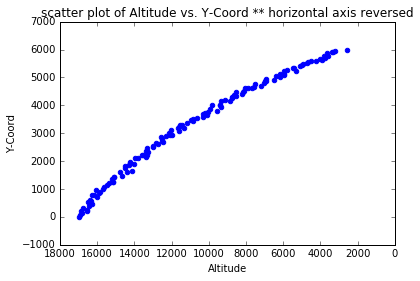

In [8]:
print 'as interpretablity experiment, take one of those (Y-coord) and reverse the X-axis'
print 'this one may make it easier to visually predict where the impact will be, as the '
print 'graph can be read left to right, as altitude decreases.'
fig = plt.figure(figsize=(6,4))
axes_1 = fig.add_subplot(1, 1, 1)

axes_1.scatter(data['zc'], 
            data['yc'], 
            color='blue')
axes_1.set_title('scatter plot of Altitude vs. Y-Coord ** horizontal axis reversed')
axes_1.set_xlabel('Altitude')
axes_1.set_ylabel('Y-Coord')

# invert axis, likely audience will tend to read things from left to right 
#   impact (Altitude=0) at right of plot will make more sense
plt.gca().invert_xaxis()
plt.show()


but this is plot that draws everything together in a visual manner
one can guess the impact will be somewhere with X-coord above 6k
and similar for the final Y-coord 


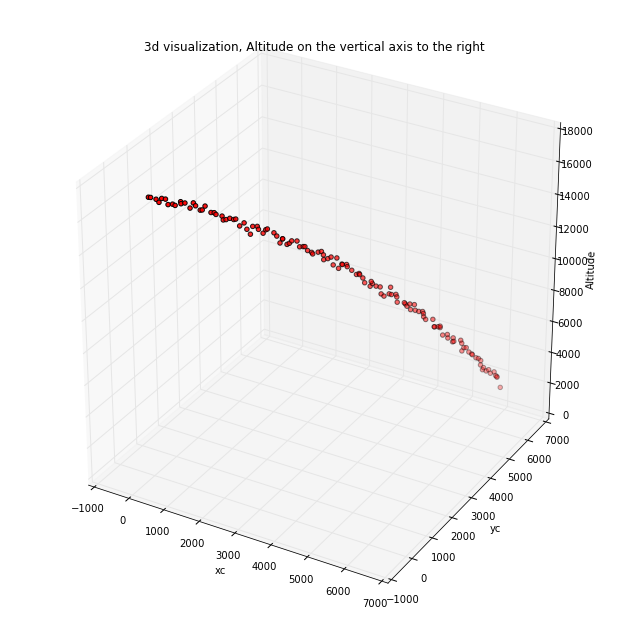

In [9]:
print
print 'but this is plot that draws everything together in a visual manner'
print 'one can guess the impact will be somewhere with X-coord above 6k'
print 'and similar for the final Y-coord '

fig = plt.figure(figsize=(11,11))
axes = fig.add_subplot(111, projection='3d')

axes.scatter(data['xc'], data['yc'], data['zc'], c='red')
axes.set_xlabel('xc')
axes.set_ylabel('yc')
axes.set_zlabel('Altitude')
axes.set_title('3d visualization, Altitude on the vertical axis to the right')


In [10]:
# from my HW3 (in turn, from Lecture 5 notebook, with additional annotations)

# --- polynomial_regression_fit:
# Fits a polynomial regression model
# using OLS module of sklearn
# Input: 
#    x_train, n x d array of coefficients 
#    y_train, n x 1 array of dependent variables
#    degree of the polynomial (integer)
# Return:
#   the model parameters (array of coefficients and the intercept)

def polynomial_regression_fit(x, y, degrees):
    
    # Create the poly terms for x,x^2 ..    
    n= np.size(y)   # data size 
    x_poly = np.zeros([n, degrees]) # poly degree 

    for d in range(1, degrees +1):
        x_poly[:, d - 1] = np.power(x, d)  # adding terms 

    Xt=sm.add_constant(x_poly)
    model=sm.OLS(y,Xt)
    model_results=model.fit()
    
    return model_results, Xt


# based off of plotit1() function from Lecture5 notebook, with modifications

def plot_models(X_test, Y_test, degree_values, x_label='X', y_label='Y'):

    plt.figure(figsize=(9, 6)) 
    #plt.gca().invert_xaxis()
    for i, degree_value in enumerate(degree_values):
        model_results, x_poly = polynomial_regression_fit(X_test, Y_test, degree_value)
        y_hat=np.dot(model_results.params, x_poly.T)
        #make up some colors, named colors would have been easy for 4 datapoints
        # below isn't great color picking but is at least a little more flexible
        color_factor = (i+1.0)/len(degree_values)
        line_color = (i % 2, 1-color_factor, color_factor)
        plt.plot(X_test, y_hat, color=line_color, alpha=0.8, label='poly '+str(degree_value) + ' degree')

    plt.plot(X_test, Y_test, 'ro', markersize=2)
    plt.xlabel(x_label); plt.ylabel(y_label)
    plt.title('Choosing a polynomial degree')
    plt.legend(loc='best')   
    
   

The earlier plots show a solid linear relationship but the slight curve indicates we may want to look into some kind of low polynomial. Some related functions have just been defined and I'll use them to try to figure out an appropriate polynomical value. Both X-Coord and Y-Coord are highly correlated and show similar relationships to Z-Coord/Altitude, so selecting for X-Coord is highly likely to result in "correct" polynomial degree for Y-Coord also.  
Below I'll plot a few low-order polynomials agains the data and see which is likely to work best.

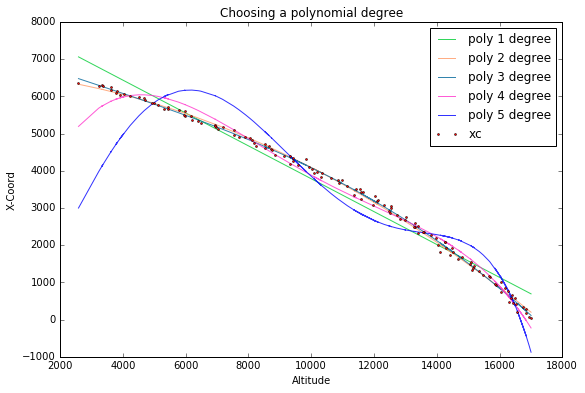

In [11]:
# Fit polynomial regression models of degrees 3, 5, 10 and 25 to the data set. 
# Visualize the original data along with the fitted models for the various degrees in the same plot.

# altitude as the independent varlable
X_data = data['zc']
Y_data = data['xc']

# line is only slightly curved, no need to go beyond 5 degrees
degrees = range(1,6)
plot_models(X_data, Y_data, degrees, x_label='Altitude', y_label='X-Coord')



Looks like poly 2 or 3 will be best for X-Coord prediction (and hence Y-Coord also). Next step will  be to pick between those two.



Using all of the existing data as training data up to this point, AIC & BIC will be appropriate 
measures to confirm which polynomial degree will be best.

Visually, it looked like either 2 or 3 would be appropriate. AIC/BIC values indicate 2 degrees will be best.



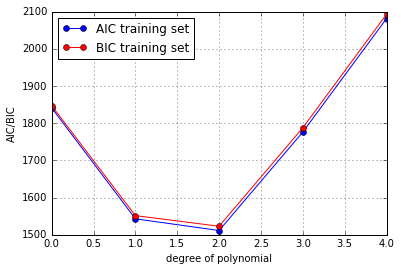

In [12]:

print '''
Using all of the existing data as training data up to this point, AIC & BIC will be appropriate 
measures to confirm which polynomial degree will be best.

Visually, it looked like either 2 or 3 would be appropriate. AIC/BIC values indicate 2 degrees will be best.
'''

# my HW3, via basically the method used in Lec 5 code

degrees = 6
AIC = np.zeros([degrees+1,1])
BIC = np.zeros([degrees+1,1])

for d in range(1, degrees):
    
    model, _ = polynomial_regression_fit(data['zc'], data['xc'], d)
    AIC[d] = model.aic
    BIC[d] = model.bic
    
# Plot the criterion values as a function of the polynomial degree.

# code snippet from Lec 5 notebook
plt.figure(figsize=(6,4))
plt.plot(AIC[1:degrees], 'bo-', label=r'AIC training set')
plt.plot(BIC[1:degrees], 'ro-', label=r'BIC training set')

plt.xlabel('degree of polynomial'); 
plt.ylabel(r'AIC/BIC')
plt.legend(loc='best')
plt.grid()

In [13]:
#some stats on what appears to be best model 
best_degree = 2
final_model_xc, _ = polynomial_regression_fit(data['zc'], data['xc'], best_degree)
final_model_xc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     xc   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.720e+04
Date:                Fri, 14 Oct 2016   Prob (F-statistic):          6.62e-168
Time:                        07:45:50   Log-Likelihood:                -768.48
No. Observations:                 130   AIC:                             1543.
Df Residuals:                     127   BIC:                             1552.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       6651.6909     50.831    130.858      0.000      6551.105  6752.277
x1            -0.0797      0.011     -7.351      0.000        -0.101    -0.058
x2         -1.763e-05    5.2e-07    -33.923      0.000     -1.87e-05 -1.66e-05
==============================================================================
Omnibus:                        1.930   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.381   Jarque-Bera (JB):                1.735
Skew:                          -0.283   Prob(JB):                        0.420
Kurtosis:                       2.995   Cond. No.                     1.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# now make the model for Y-coord prediction

final_model_yc, _ = polynomial_regression_fit(data['zc'], data['yc'], best_degree)
final_model_yc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     yc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.235e+04
Date:                Fri, 14 Oct 2016   Prob (F-statistic):          1.66e-162
Time:                        07:45:50   Log-Likelihood:                -772.78
No. Observations:                 130   AIC:                             1552.
Df Residuals:                     127   BIC:                             1560.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       6217.7606     52.542    118.338      0.000      6113.789  6321.732
x1            -0.0724      0.011     -6.455      0.000        -0.095    -0.050
x2         -1.663e-05   5.37e-07    -30.959      0.000     -1.77e-05 -1.56e-05
==============================================================================
Omnibus:                        1.809   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.871
Skew:                          -0.255   Prob(JB):                        0.392
Kurtosis:                       2.707   Cond. No.                     1.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the numbers above, things seem to be going along just fine, though using these models to predict affected population in later step strongly implies something has gone off the rails. I came back and tried to figure things out but didn't have time to see what the problem was... assuming it wasn't in the approach entirely. Either way, I added some plots as a sanity check and they seem to agree with the idea that the models are good, or at least reasonable.


Re-check my models against the orig data.


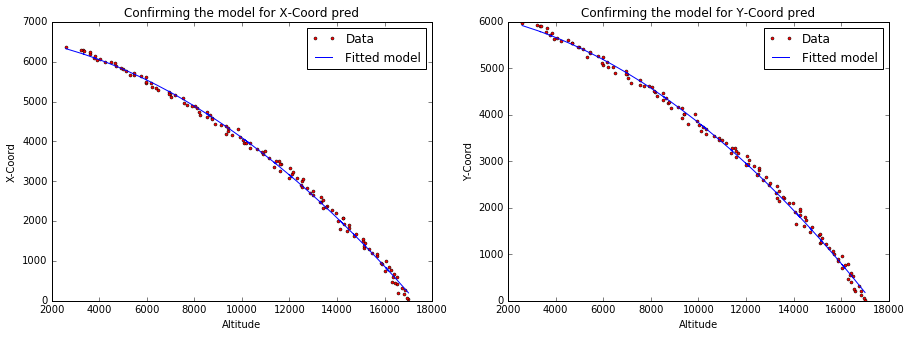

In [15]:
print
print 'Re-check my models against the orig data.'
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(data['zc'], data['xc'], 'ro', markersize=3)
ax1.plot(data['zc'], final_model_xc.fittedvalues, 'b')
ax1.legend(['Data', 'Fitted model'])
ax1.set_xlabel('Altitude')
ax1.set_ylabel('X-Coord')
ax1.set_title('Confirming the model for X-Coord pred')

ax2.plot(data['zc'], data['yc'], 'ro', markersize=3)
ax2.plot(data['zc'], final_model_yc.fittedvalues, 'b')
ax2.legend(['Data', 'Fitted model'])
ax2.set_xlabel('Altitude')
ax2.set_ylabel('Y-Coord')
ax2.set_title('Confirming the model for Y-Coord pred')



Above summaries show the two models are very similar, as expected, but perhaps enough reason to keep separate models.
Given that I am using simple linear regression, I haven't been able to come up with a very good reason to do any train/test splits. 

In [16]:
# my HW3 (via lec 05 code)

# polynomial_regression_predict:
#   takes as input: the model parameters (array of coefficients and the intercept), 
#     the degree of the polynomial and the test set predictors x_test
#   returns the response values predicted by the model on the test set.

# from Lecture 5 notebook, with additional annotations

# --- polynomial_regression_predict:
# Return predictions based on model, polynomial degree, and test data
# Input: 
#    1 x d array of coefficients and the intercept 
#    degree of the polynomial (integer)
#    n x d array of test predictors
# Return:
#   returns n x 1 array of predicted values

def polynomial_regression_predict(params, degrees, x):

    # # Create the poly terms for x,x^2 ..
    n = x.shape[0]
    x_poly = np.zeros([n, degrees])
    for d in range(1, degrees + 1):
        x_poly[:, d - 1] = np.power(x, d)
    Xt=sm.add_constant(x_poly)

    # Predict y-vals
    y_pred = np.dot(params,Xt.T)
        
    return y_pred

In [17]:

# something funky, matrix-multiplication-wise, going on when I try passing a single value to the predict function
#  similar with two zeroes, don't have time to figure it out, going with below and peel off the zero prediction
def get_impact_estimate(model_params):
    best_degree = 2
    zeros = np.array([0.1,0])
    coord_at_impact = polynomial_regression_predict(model_params, best_degree, zeros)
    
    #return only the estimate related to zero, though of course the 0.1 pred is very close to that
    return coord_at_impact[-1]

print 'Estimated point of impact:'
print '  X-Coord: {}'.format(get_impact_estimate(final_model_xc.params))
print '  Y-Coord: {}'.format(get_impact_estimate(final_model_yc.params))


Estimated point of impact:
  X-Coord: 6651.69093222
  Y-Coord: 6217.76061351


In [18]:
# come up with some confidence interval info, base code from my HW, which in turn derived from Lab3 notebook

best_degree = 2

x = np.array(data['zc'])
y1 = np.array(data['xc'])
y2 = np.array(data['yc'])

# - Create 200 random subsamples of the data set of size 100
# Record size of the data set
n = x.shape[0]
#d = 1 # x.shape[1]

# Size of data set, and subsample (~20%)
subsample_size = 25
# No. of subsamples
num_samples = 200
    
# Create lists to store params for subsamples
# I went through a few different approaches here, beginning with tracking the two coefficients (poly1, poly2)
#  from my model. But I realized that if Y/predictor=0, the coefficients wouldn't tell us anything.
# So I wound up grabbing the intercepts for both xc and yc models and using those. At this point I was 
#  fully committed to my approach (at least in terms of remaining time for midterm), so I had to go with what
#  seemed to produce reasonable results, and this was it.
coef1 = []
coef2 = []
# actually, the independent variable, altitude, will be zero, at that point only care about intercepts
#  since all the coefficients will be multiplied by zero
y1_intercepts = []
y2_intercepts = []

# Repeat for 200 subsamples
# - and use your function to fit a multiple linear regression model to each subsample.
for i in range(num_samples):
    # Generate a random subsample of 50 data points
    perm = np.random.permutation(n) # Generate a list of indices 0 to n and permute it
    x_subsample = x[perm[:subsample_size]] # Get x-vals for the first 50 indices in permuted list
    
    y1_subsample = y1[perm[:subsample_size]] # Get y-vals for the first 50 indices in permuted list
    y2_subsample = y2[perm[:subsample_size]] 

    # generate separate models for both x-coord & y-coord
    model_xc, _ = polynomial_regression_fit(x_subsample, y1_subsample, best_degree)
    model_yc, _ = polynomial_regression_fit(x_subsample, y2_subsample, best_degree)
    
    # Store the coefficient for the model we obtain... though at the end I don't do anything with the coef1/2
    coef1.append(model_xc.params[1])
    coef2.append(model_xc.params[2])
    # put in the intercepts for xc/yc models
    y1_intercepts.append(model_xc.params[0])
    y2_intercepts.append(model_yc.params[0])
    


In [19]:
# **** all the coeff estimations don't matter if the independent variable, i.e. altitude aka zc = 0 ****
#coef1_conf_int_left = np.percentile(coef1, 5)
#coef1_conf_int_right = np.percentile(coef1, 95)
#coef2_conf_int_left = np.percentile(coef2, 5)
#coef2_conf_int_right = np.percentile(coef2, 95)
#print 'conf interval for X-Coord coeff: [{0}, {1}]'.format(coef1_conf_int_left, coef1_conf_int_right)
#print 'conf interval for 2nd degree polynomial of coord: [{0}, {1}]'.format(coef2_conf_int_left, coef2_conf_int_right)

# its been a while, print this info again
print 'Estimated point of impact:'
print '  X-Coord: {}'.format(get_impact_estimate(final_model_xc.params))
print '  Y-Coord: {}'.format(get_impact_estimate(final_model_yc.params))

# except for the fact that things are apparenlty quite a ways off track, everything seems fine at this point
xc_intercept_conf_int_left = np.percentile(y1_intercepts, 5)
xc_intercept_conf_int_right = np.percentile(y1_intercepts, 95)
print '90% conf interval for X-Coord intercept: [{0}, {1}]'.format(xc_intercept_conf_int_left, xc_intercept_conf_int_right)

yc_intercept_conf_int_left = np.percentile(y2_intercepts, 5)
yc_intercept_conf_int_right = np.percentile(y2_intercepts, 95)
print '90% conf interval for Y-Coord intercept: [{0}, {1}]'.format(yc_intercept_conf_int_left, yc_intercept_conf_int_right)


Estimated point of impact:
  X-Coord: 6651.69093222
  Y-Coord: 6217.76061351
90% conf interval for X-Coord intercept: [6371.028416, 6822.26156102]
90% conf interval for Y-Coord intercept: [5907.4627844, 6366.55775874]


-----

In [20]:
# Now for estimates on the affected population
pop = pd.read_csv('pop_data.csv')
# take a peek at the data and immediately see a problem
pop.head(10)


,residents,bed,bath,x,y
0,3,4,3,7201.60,6752.56
1,2,2,1,7079.68,6622.32
2,4,2,1,7154.40,6683.28
3,2,1,2,7093.44,6680.56
4,1,2,2,7198.72,6674.96
5,0,2,1,7101.76,6655.60
6,3,2,1,7157.28,6652.72
7,NaN,3,5,7088.00,6749.84
8,3,2,1,7160.00,6525.36
9,1,1,1,7201.60,6627.76


In [21]:
# now to do a more thorough check for any missing values, .info() should help
print pop.info()
print
print
print 'Looks like residents is the only null-ish variable to be concerned with here using this method'
print 'of course more thorough methods of reviewing that data are appropriate, but not going to happen'
print 'in the midterm timeframe'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 0 to 2416
Data columns (total 5 columns):
residents    1656 non-null float64
bed          2417 non-null int64
bath         2417 non-null int64
x            2417 non-null float64
y            2417 non-null float64
dtypes: float64(3), int64(2)
memory usage: 113.3 KB
None


Looks like residents is the only null-ish variable to be concerned with here using this method
of course more thorough methods of reviewing that data are appropriate, but not going to happen
in the midterm timeframe


In [22]:
# create a good_pop df to hold the data that does have residents values
good_pop = pop[pop['residents'].notnull()]
# calculate some aggregate values for average number of residents given a number of beds (and then for # baths)
bed_pop = good_pop.groupby('bed', as_index=False).agg({'residents': np.mean})
bath_pop = good_pop.groupby('bath', as_index=False).agg({'residents': np.mean})

print bed_pop.head()
print
print bath_pop.head()

   bed  residents
0    1   1.202703
1    2   2.091873
2    3   2.718182
3    4   3.444444
4    5   4.021739

   bath  residents
0     1   1.883257
1     2   2.185965
2     3   2.421053
3     4   2.594340
4     5   2.979167


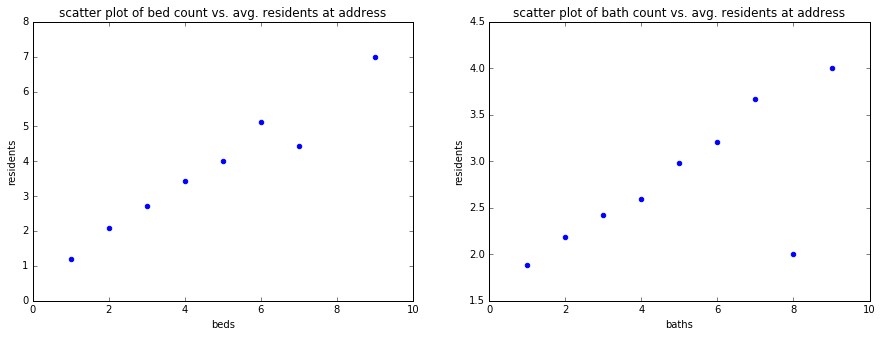

In [23]:
# plot the groupby results, both bed & bath values have linear relationship to avg # residents in that abode
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(bed_pop['bed'], 
            bed_pop['residents'], 
            color='blue')
ax1.set_title('scatter plot of bed count vs. avg. residents at address')
ax1.set_xlabel('beds')
ax1.set_ylabel('residents')

ax2.scatter(bath_pop['bath'], 
            bath_pop['residents'], 
            color='blue')
ax2.set_title('scatter plot of bath count vs. avg. residents at address')
ax2.set_xlabel('baths')
ax2.set_ylabel('residents')



We can see both bed and bath counts have a linear relationship to number of residents. Bed count info data is good enough go forward but the baths = 8 aggregate mean appears to be an outlier, examine further.

In [24]:
# how many residences have 8 baths? 
good_pop[good_pop['bath']==8]

,residents,bed,bath,x,y
1212,2,3,8,7065.76,6550.16


In [25]:
# only one residence with bath count = 8, seems perfectly reasonable to treat as an outlier
#  and remove from the data that will be used to fill rows with missing # residents
# set good_pop to th 1655 observations with residents values but without 8 baths
good_pop = good_pop[good_pop['bath']!=8]
len(good_pop)

1655

Choosing between KNN and Linear Regression models in order to fill in the missing residents values, the latter seems a reasonabl approach given the linear relationship(s) between the bed/bath counts and the number of residents. No strange shapes or clustering visible in the limited aggregate data I've compiled.

In [26]:

# some of below ulimately derives from Lab 2 notebook

# separate those with residents values from those without
no_y_ind = pop[pop['residents'].isnull()].index
with_y_ind = pop[pop['residents'].notnull()].index
# get the predictors for those with full data
x_train = pop.loc[with_y_ind, ['bed', 'bath']]
# and the dependent values for same
y_train = pop.loc[with_y_ind, 'residents']
# now assemble those missing the value we want to predict
x_test = pop.loc[no_y_ind, ['bed', 'bath']]
#fit linear model
regression = Lin_Reg()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)

# could have set to pop directly but want to sanity check the results first
predicted_df = pop.copy()
predicted_df.loc[no_y_ind, 'residents'] = pd.Series(predicted_y, index=no_y_ind)

print 'ok, looks like mission accomplished, rows with missing residents now populated'
predicted_df.loc[no_y_ind].head()


ok, looks like mission accomplished, rows with missing residents now populated


,residents,bed,bath,x,y
7,2.536599,3,5,7088.00,6749.84
23,2.820533,3,1,7168.32,6650.00
29,2.820533,3,1,7135.04,6705.36
30,1.997885,2,2,7281.92,6611.28
38,4.110911,5,4,7146.08,6763.60


In [27]:
# lets set pop to the fully populated df and check for missing values again, looks good
pop = predicted_df
pop.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 0 to 2416
Data columns (total 5 columns):
residents    2417 non-null float64
bed          2417 non-null int64
bath         2417 non-null int64
x            2417 non-null float64
y            2417 non-null float64
dtypes: float64(3), int64(2)
memory usage: 113.3 KB


My data from earlier

Estimated point of impact:  
- X-Coord: 6651.69093222  
- Y-Coord: 6217.76061351  
  
(one of my iterations at least)  
90% conf interval for X-Coord intercept: [6457.77276842, 6829.81324294]  
90% conf interval for Y-Coord intercept: [5979.1673719, 6404.42774689]

In [28]:
# get abodes in the area covered by my confidence intervals
affected = pop[(pop['x'] >= xc_intercept_conf_int_left) & (pop['x'] <= xc_intercept_conf_int_right) 
               & (pop['y'] >= yc_intercept_conf_int_left) & (pop['y'] <= yc_intercept_conf_int_right) ]

affected

,residents,bed,bath,x,y


Yay, no one in the supplied population list will be affected.  
  
Or something had gone horribly wrong with my model creation and/or the entire approach in that part. Going by my gut, what seems likely midterm-wise, and just visually looking at both the raw data and my initial plots, I'm going with the horribly wrong part.  

What's left is to dummy up some face confidence intervals taking the actual pop_data.csv data into account and derive some further fake numbers. (I'm entering 0 as the number of people affected in the midterm question though, since that is what I came up with and the numbers below are entirely arbitrary).

In [29]:
x_fake_left_ci = 7100
x_fake_right_ci = 7150
y_fake_left_ci = 6650
y_fake_right_ci = 6700

affected = pop[(pop['x'] >= x_fake_left_ci) & (pop['x'] <= x_fake_right_ci) 
               & (pop['y'] >= y_fake_left_ci) & (pop['y'] <= y_fake_right_ci) ]

people_affected = affected['residents'].sum()

print 'Number of people in impact region, given arbitrary confidence intervals: {}'.format(int(round(people_affected,0)))

Number of people in impact region, given arbitrary confidence intervals: 233
